# Biomedical Dataset Overview

This dataset was curated by **Dr. Henrique da Mota** during his medical residency in **Lyon, France**. It aims to represent each patient with a comprehensive set of biomechanical attributes that reflect the shape and orientation of the pelvis and lumbar spine. These attributes are critical in the diagnosis and understanding of various spinal conditions.

## Dataset Attributes

Patients are characterized by the following six biomechanical attributes:

- **Pelvic Incidence**: A numerical value indicating the angle of the pelvis.
- **Pelvic Tilt**: The tilt of the pelvis measured in degrees.
- **Lumbar Lordosis Angle**: The curvature angle of the lumbar spine.
- **Sacral Slope**: The slope of the sacral region of the spine.
- **Pelvic Radius**: A measure of the pelvic cavity's radius.
- **Grade of Spondylolisthesis**: The severity of spondylolisthesis present.

## Classification Labels

The dataset categorizes patients into four distinct classes based on their spinal conditions:

- **Disk Hernia (DH)**
- **Spondylolisthesis (SL)**
- **Normal (NO)**
- **Abnormal (AB)**

For this analysis, we focus on a binary classification task. The labels are simplified as follows:

- **Normal (NO)**: Represented as `0`
- **Abnormal (AB)**: Represented as `1`


# Libraries

In [1]:
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
from scipy.io import arff
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# (a) Loading Data

Get the Vertebral Column Data Set

In [5]:
dat_column_2C = pd.read_csv('../data/vertebral_column_data/column_2C.dat')
dat_column_3C = pd.read_csv('../data/vertebral_column_data/column_3C.dat')

### Loading ARFF file

In [6]:
# Load ARFF file into pandas df
column_2C, column_2C_meta = arff.loadarff('../data/vertebral_column_data/column_2C_weka.arff')
column_2C = pd.DataFrame(column_2C)

column_3C, column_3C_meta = arff.loadarff('../data/vertebral_column_data/column_3C_weka.arff')
column_3C = pd.DataFrame(column_3C)

### Inspect dataframe

In [7]:
print("column_2C:")
column_2C.head()

column_2C:


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Abnormal'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Abnormal'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Abnormal'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Abnormal'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Abnormal'


### Here I am converting the classes 'Normal, Abnormal' to [0, 1]

In [8]:
column_2C['class'] = column_2C['class'].str.decode('utf-8')
column_2C['class'] = column_2C['class'].map({'Normal': 0, 'Abnormal': 1})

In [9]:
column_2C.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


# (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

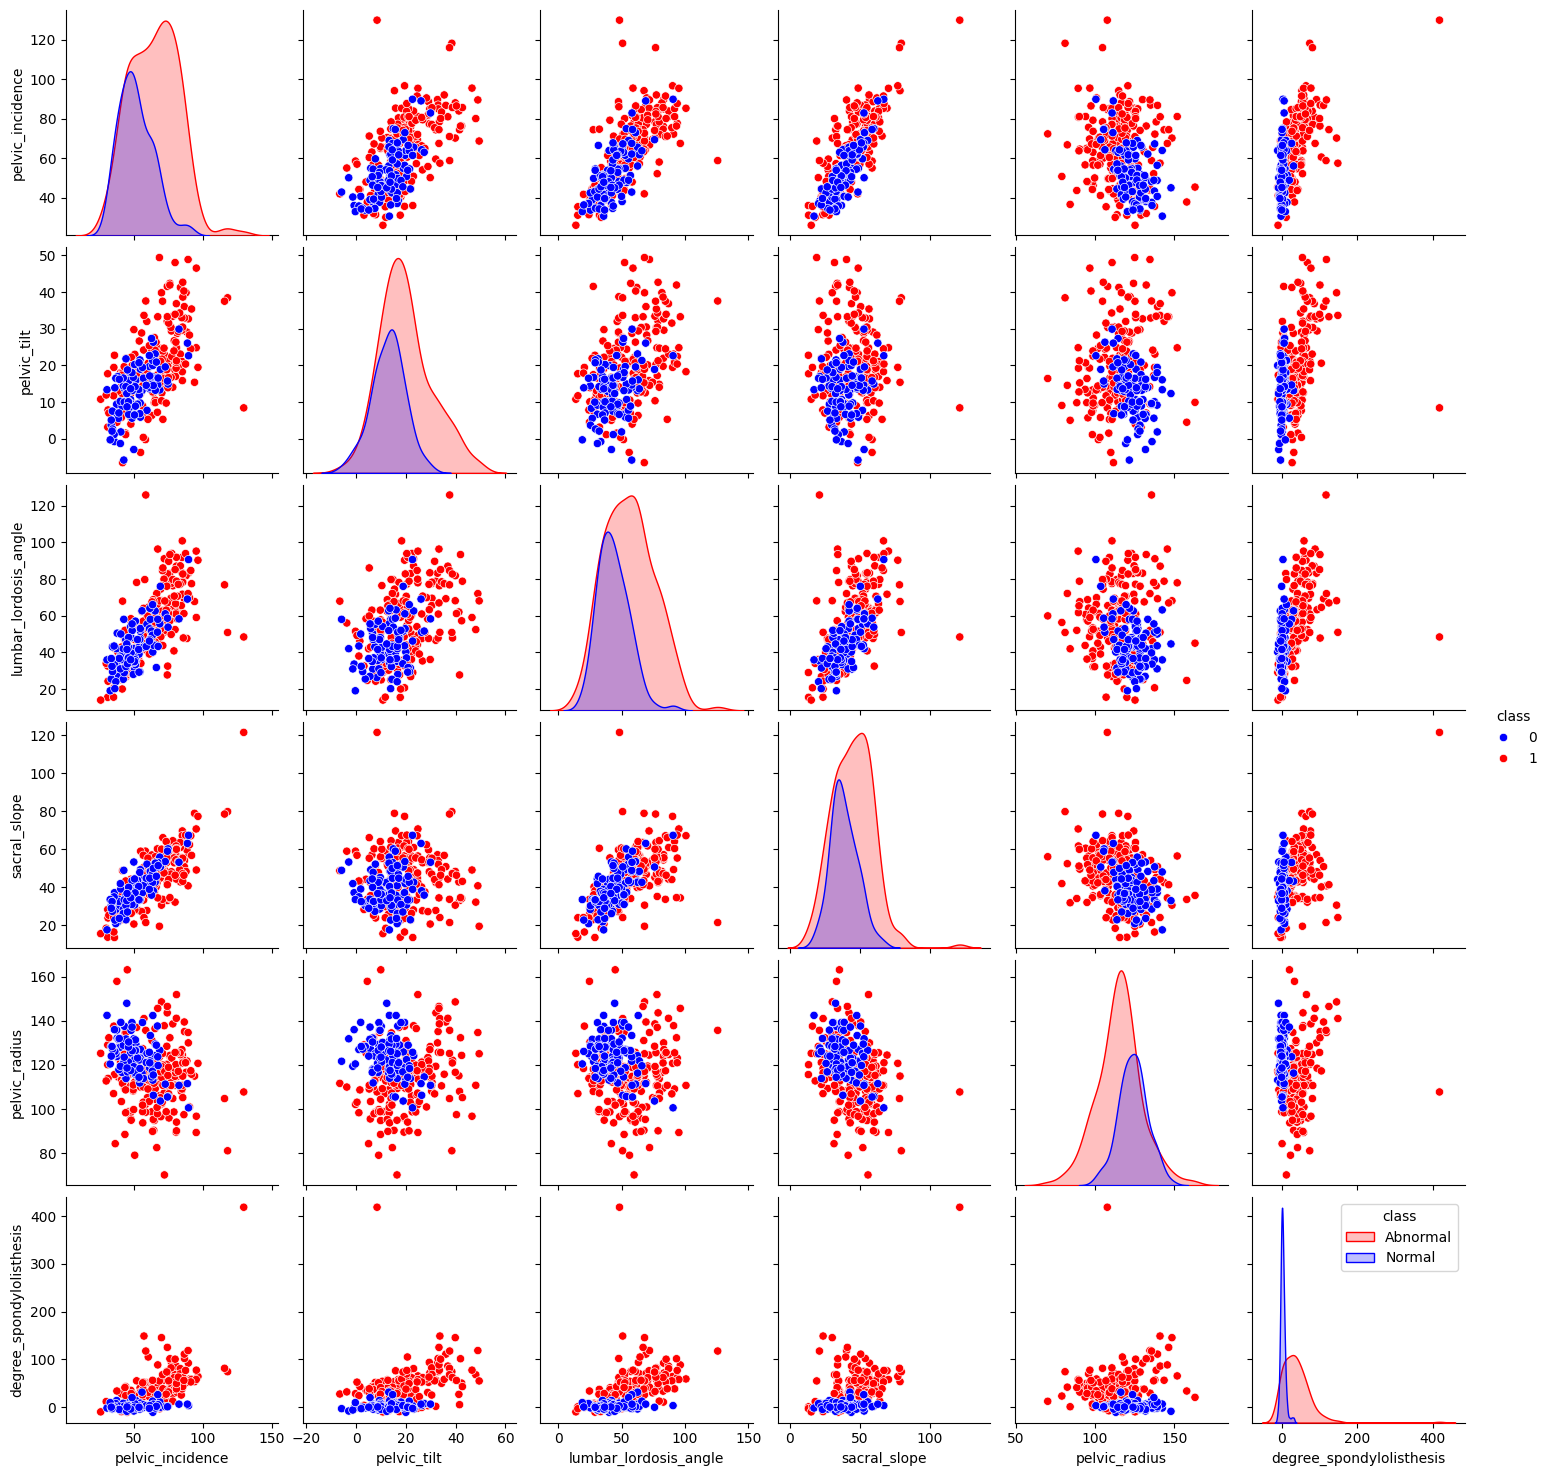

In [10]:
# Getting independent variables from df
ind_vars = column_2C.columns.tolist()
ind_vars.remove('class')

# Getting the dependent variables from df
dep_var = 'class'

# Scatterplot of data
data = column_2C[ind_vars + [dep_var]]
sns.pairplot(data, hue=dep_var, palette={0: 'blue', 1: 'red'})
plt.legend(title=dep_var, loc='upper right', labels=['Abnormal', 'Normal'])
plt.show()


#### ii. Boxplots

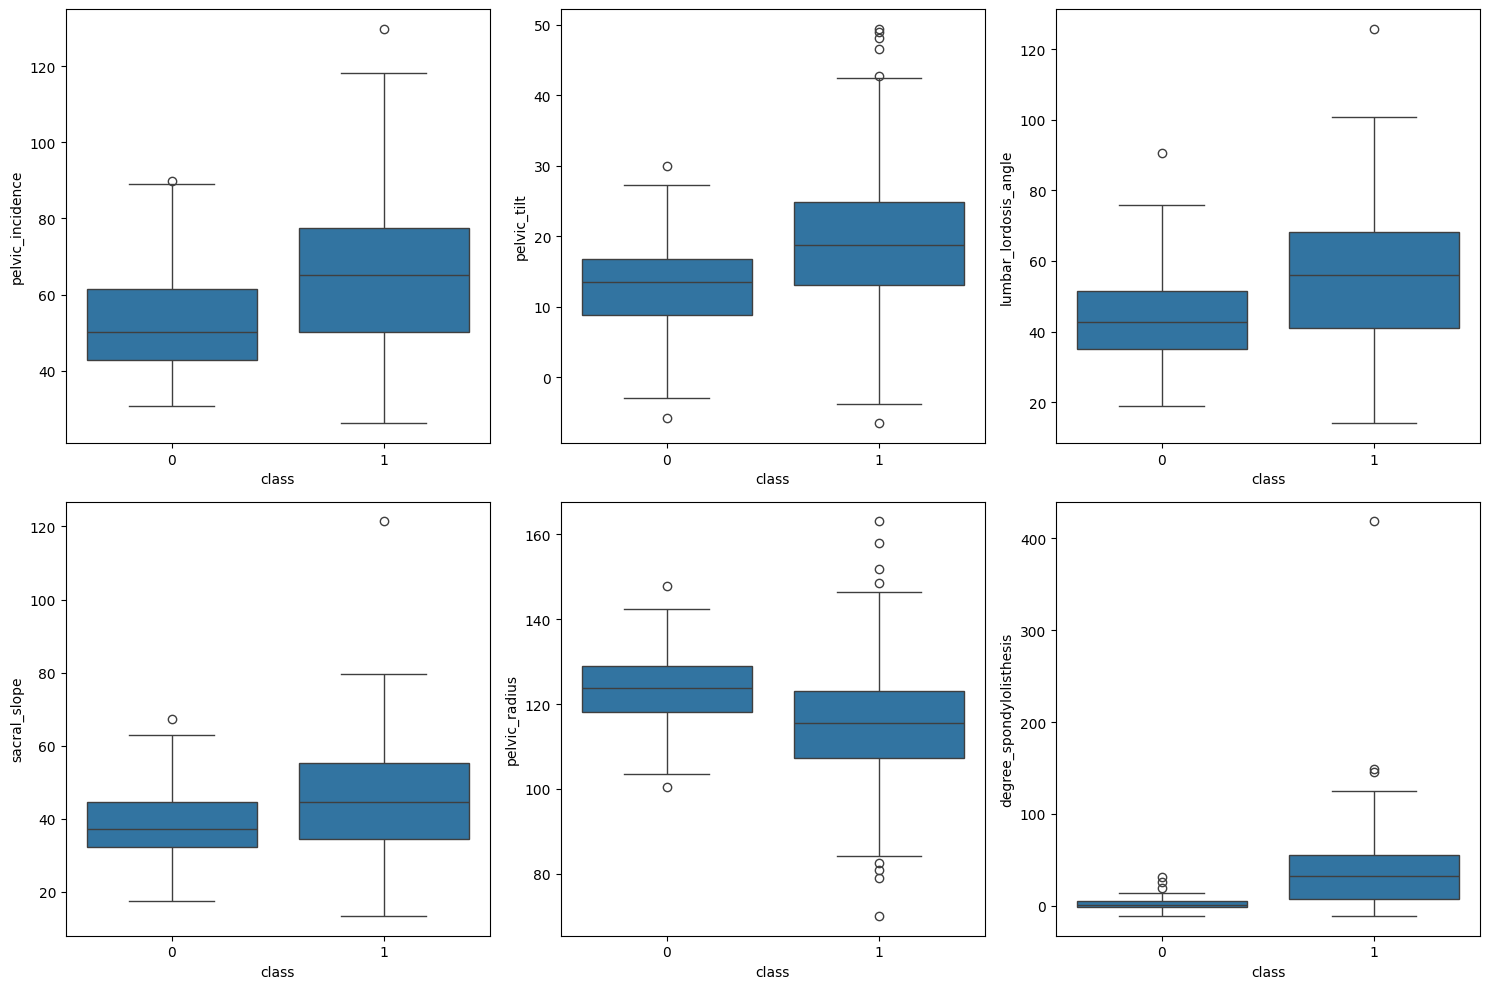

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for ax, var in zip(axs.flatten(), ind_vars):
    sns.boxplot(x=dep_var, y=var, data=column_2C, ax=ax)
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

#### iii. Split Data Set 

Selecting the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [12]:
train_class_0 = column_2C[column_2C['class'] == 0].iloc[:70]
train_class_1 = column_2C[column_2C['class'] == 1].iloc[:140]

train_set = pd.concat([train_class_0, train_class_1], axis=0)
test_set = column_2C.drop(train_set.index)

# (c) Classification

## i. Euclidean Metric

In [13]:
X_train = train_set[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
y_train = train_set['class']

X_test = test_set[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
y_test = test_set['class']

## ii. Test Data

In [14]:
# Define a range of k values to test (in reverse order)
k_values = list(range(208, 0, -1))

# Initialize lists to store train and test errors
train_errors = []
test_errors = []

# Run KNN (Euclidian Metric) over all values of k
for k in k_values:
    
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    
    y_train_pred = knn_classifier.predict(X_train)
    y_test_pred = knn_classifier.predict(X_test)
    
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    
    train_errors.append(train_error)
    test_errors.append(test_error)

### Plotting training and testing errors against k

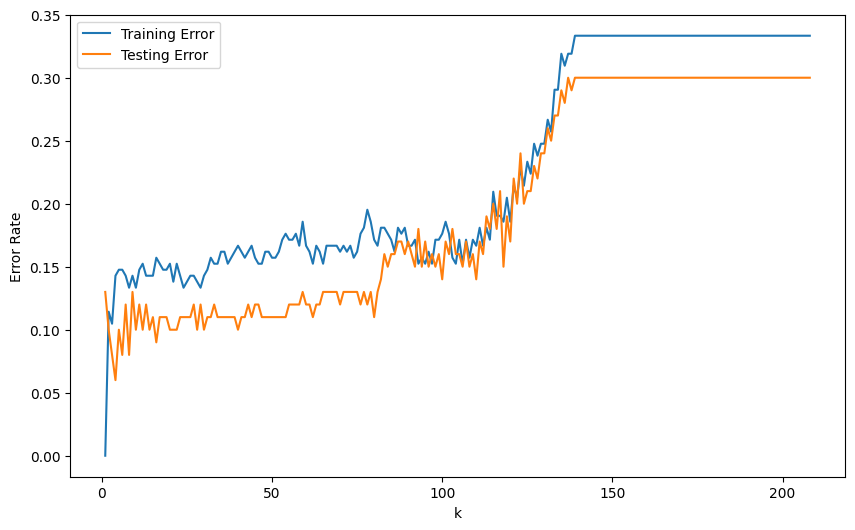

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_errors, label='Training Error')
plt.plot(k_values, test_errors, label='Testing Error')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

In [16]:
# Find the most suitable k (k∗) with the lowest test error
lowest_k_index = test_errors.index(min(test_errors))
best_k = k_values[lowest_k_index]
print(f'The best K value for the Euclidian KNN is {best_k}')

The best K value for the Euclidian KNN is 4


When k=4: 
True Positive Rate: 0.99
True Positive Rate: 0.99
True Negative Rate: 0.83
Precision: 0.93
F1-Score: 0.96


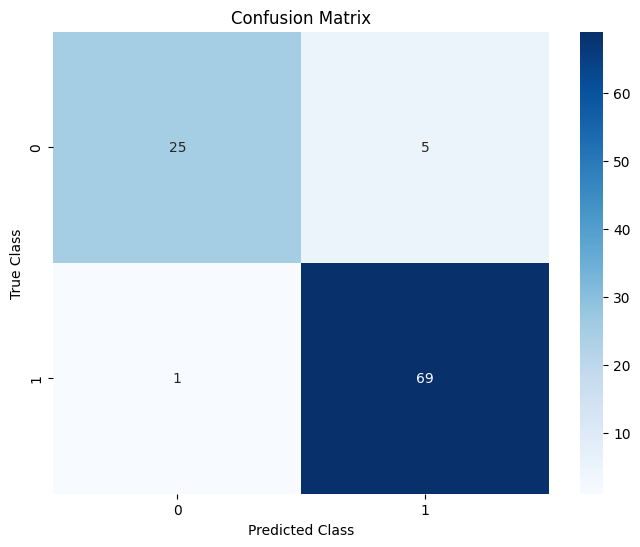

In [17]:
# Redoing model with k=4
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train, y_train)
y_test_pred = knn_classifier.predict(X_test)

# Calculate confusion matrix, true positive rate, true negative rate, precision, and F1-score
confusion = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = confusion.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
precision = tp / (tp + fp)
f1_score = 2 * (precision * tpr) / (precision + tpr)

print("When k=4: ")
print(f"True Positive Rate: {tpr:.2f}")
print(f"True Positive Rate: {tpr:.2f}")
print(f"True Negative Rate: {tnr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1_score:.2f}")

# Confusion matrix grid
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

### iii. Learning Curve

In [18]:
y_train_pred = knn_classifier.predict(X_train)
y_test_pred = knn_classifier.predict(X_test)

train_error = 1 - accuracy_score(y_train, y_train_pred)
test_error = 1 - accuracy_score(y_test, y_test_pred)

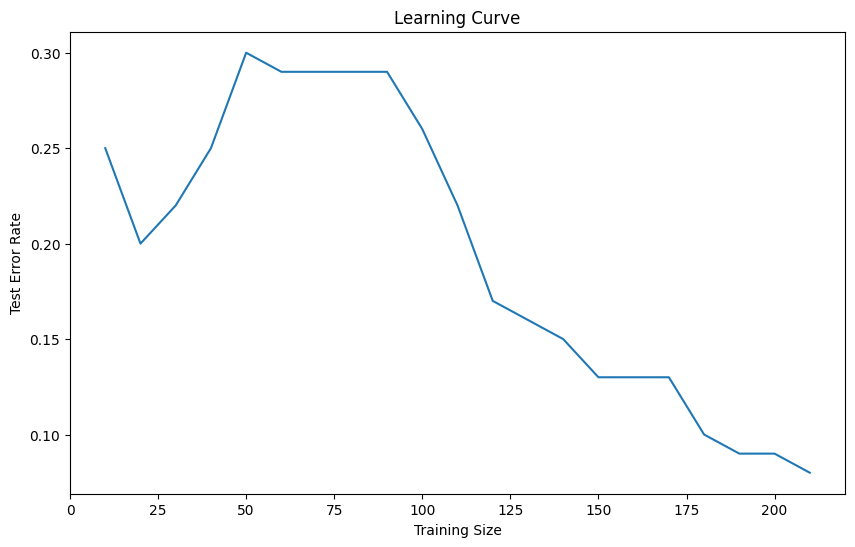

The lowest test error rate achieved was with an N of 0.07999999999999996
Along with an associated k of 6


In [19]:
training_set_size = list(range(10, 211, 10))

best_test_errors = []
best_training_errors = []
best_k_values = []

for N in training_set_size:
    
    train_class_0_selected_N = train_class_0.iloc[:N // 3]
    train_class_1_selected_N = train_class_1.iloc[:N - N // 3]
    train_set = pd.concat([train_class_0_selected_N, train_class_1_selected_N], axis=0)
    
    # Extract features and target from the training set
    X_train = train_set[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
    y_train = train_set['class']

    # Initialize variables to store the best error rate and corresponding k
    best_error_rate = float('inf')
    best_k = None

    # Create KNN models iterating though range of k values based on N
    for k in range(1, N + 1, 5):
        
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(X_train, y_train)
        
        y_train_pred = knn_classifier.predict(X_train)
        y_test_pred = knn_classifier.predict(X_test)

        train_error_rate = 1 - accuracy_score(y_train, y_train_pred)
        test_error_rate = 1 - accuracy_score(y_test, y_test_pred)

        if test_error_rate < best_error_rate:
            best_error_rate = test_error_rate
            best_k = k
        

    # Here you can add the best test errors achieved with the associated k value
    best_test_errors.append(best_error_rate)
    best_k_values.append(best_k)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(training_set_size, best_test_errors)
plt.xlabel('Training Size')
plt.ylabel('Test Error Rate')
plt.title('Learning Curve')
plt.show()


print(f"The lowest test error rate achieved was with an N of {min(best_test_errors)}")
print(f"Along with an associated k of {best_k_values[best_test_errors.index(min(best_test_errors))]}")

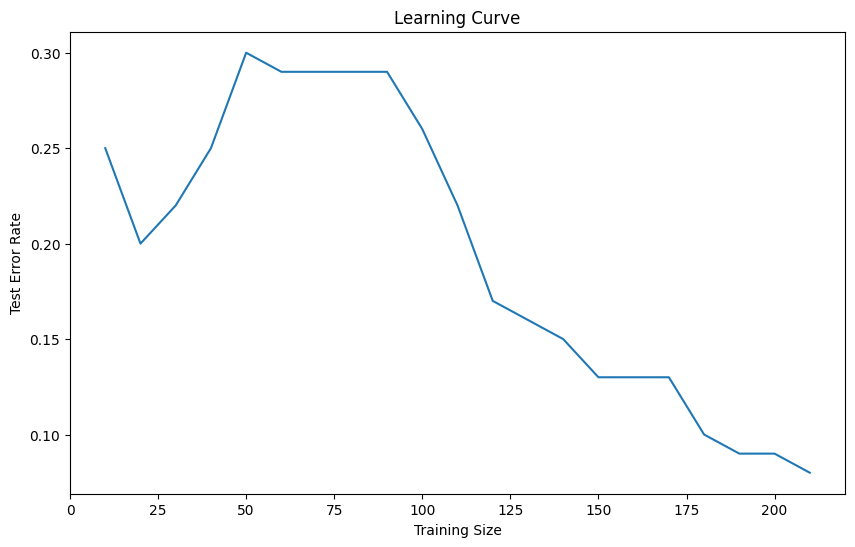

The lowest test error rate achieved was with an N of 0.07999999999999996
Along with an associated k of 6


In [20]:
training_set_size = list(range(10, 211, 10))

best_test_errors = []
best_training_errors = []
best_k_values = []

for N in training_set_size:
    
    train_class_0_selected_N = train_class_0.iloc[:N // 3]
    train_class_1_selected_N = train_class_1.iloc[:N - N // 3]
    train_set = pd.concat([train_class_0_selected_N, train_class_1_selected_N], axis=0)
    
    # Extract features and target from the training set
    X_train = train_set[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
    y_train = train_set['class']

    # Initialize variables to store the best error rate and corresponding k
    best_error_rate = float('inf')
    best_k = None

    # Create KNN models iterating though range of k values based on N
    for k in range(1, N + 1, 5):
        
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(X_train, y_train)
        
        y_train_pred = knn_classifier.predict(X_train)
        y_test_pred = knn_classifier.predict(X_test)

        train_error_rate = 1 - accuracy_score(y_train, y_train_pred)
        test_error_rate = 1 - accuracy_score(y_test, y_test_pred)

        if test_error_rate < best_error_rate:
            best_error_rate = test_error_rate
            best_k = k
        

    # Here you can add the best test errors achieved with the associated k value
    best_test_errors.append(best_error_rate)
    best_k_values.append(best_k)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(training_set_size, best_test_errors)
plt.xlabel('Training Size')
plt.ylabel('Test Error Rate')
plt.title('Learning Curve')
plt.show()


print(f"The lowest test error rate achieved was with an N of {min(best_test_errors)}")
print(f"Along with an associated k of {best_k_values[best_test_errors.index(min(best_test_errors))]}")

# (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.

In [21]:
best_test_error_rate_manhattan = float('inf')
best_train_error_rate_manhattan = float('inf')
best_k_manhattan = None

# Calculate Manhattan Distance (p=1) using the entire training set
for k in range(4, 200, 5):
    knn_classifier_manhattan = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn_classifier_manhattan.fit(X_train, y_train)

    # Make predictions on the test data
    y_train_pred = knn_classifier_manhattan.predict(X_train)
    y_test_pred = knn_classifier_manhattan.predict(X_test)

    # Calculate the test error rate
    train_error_rate_manhattan = 1 - accuracy_score(y_train, y_train_pred)
    test_error_rate_manhattan = 1 - accuracy_score(y_test, y_test_pred)
    
    # Update the best error rate and k
    if test_error_rate_manhattan < best_test_error_rate_manhattan:
        best_test_error_rate_manhattan = test_error_rate_manhattan
        best_k_manhattan = k
        
    if train_error_rate_manhattan < best_train_error_rate_manhattan:
        best_train_error_rate_manhattan = train_error_rate_manhattan
        best_k_manhattan = k

# Print the best test error rate and k for Manhattan Distance
print(f"Best Test Error Rate for Manhattan Distance (p=1): {best_test_error_rate_manhattan}")
print(f"Best Train Error Rate for Manhattan Distance (p=1): {best_train_error_rate_manhattan}")
print(f"Best k for Manhattan Distance (p=1): {best_k_manhattan}")

Best Test Error Rate for Manhattan Distance (p=1): 0.09999999999999998
Best Train Error Rate for Manhattan Distance (p=1): 0.1333333333333333
Best k for Manhattan Distance (p=1): 4


##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [22]:
# Initialize variables to store results
best_test_error_rate_minkowski = float('inf')
best_train_error_rate_minkowski = float('inf')
best_p = None

# Setting k=4 based on best k discovered for Manhattan Distance.
k = 4

# Iterate over log10(p) values
log_p_values = np.arange(0.1, 1.1, 0.1)

for log_p in log_p_values:
    p_value = 10 ** log_p
    
    knn_classifier_minkowski = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p_value)
    knn_classifier_minkowski.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_train_pred = knn_classifier_minkowski.predict(X_train)
    y_test_pred = knn_classifier_minkowski.predict(X_test)
    
    # Calculate the test error rate
    train_error_rate_minkowski = 1 - accuracy_score(y_train, y_train_pred)
    test_error_rate_minkowski = 1 - accuracy_score(y_test, y_test_pred)
    
    # Update the best error rate and p
    if test_error_rate_minkowski < best_test_error_rate_minkowski:
        best_test_error_rate_minkowski = test_error_rate_minkowski
        best_p = p_value
        
    if train_error_rate_minkowski < best_train_error_rate_minkowski:
        best_train_error_rate_minkowski = train_error_rate_minkowski

# Print the best test error rate and p for Minkowski Distance
print(f"Best Test Error Rate for Minkowski Distance: {best_test_error_rate_minkowski}")
print(f"Best Train Error Rate for Minkowski Distance: {best_train_error_rate_minkowski}")
print(f"Best p for Minkowski Distance: {best_p}")

Best Test Error Rate for Minkowski Distance: 0.06000000000000005
Best Train Error Rate for Minkowski Distance: 0.12857142857142856
Best p for Minkowski Distance: 1.5848931924611136


##### C. Chebyshev Distance With p -> infinity.

In [23]:
best_test_error_rate_chebyshev = float('inf')
best_train_error_rate_chebyshev = float('inf')

# Set k to 1
k = 4

# Create KNN classifier with Chebyshev distance
knn_classifier_chebyshev = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
knn_classifier_chebyshev.fit(X_train, y_train)

# Make predictions on the test data
y_train_pred = knn_classifier_chebyshev.predict(X_train)
y_test_pred = knn_classifier_chebyshev.predict(X_test)

# Calculate the test error rate
train_error_rate_chebyshev = 1 - accuracy_score(y_train, y_train_pred)
test_error_rate_chebyshev = 1 - accuracy_score(y_test, y_test_pred)

# Update the best error rate if a better one is found
if test_error_rate_chebyshev < best_test_error_rate_chebyshev:
    best_test_error_rate_chebyshev = test_error_rate_chebyshev

if train_error_rate_chebyshev < best_train_error_rate_chebyshev:
    best_train_error_rate_chebyshev = train_error_rate_chebyshev
    
# Print the best test error rate for Chebyshev Distance
print(f"Best Test Error for Chebyshev Distance: {best_test_error_rate_chebyshev}")
print(f"Best Train Error for Chebyshev Distance: {best_train_error_rate_chebyshev}")

Best Test Error for Chebyshev Distance: 0.09999999999999998
Best Train Error for Chebyshev Distance: 0.14761904761904765


#### ii. Mahalanobis Distance.

In [24]:
# Computing the pseudoinverse of the covariance matrix (required for the mahalanobis metric )
cov_matrix = np.cov(X_train, rowvar=False)
pseudo_inv_cov_matrix = np.linalg.pinv(cov_matrix)

best_test_error_rate_mahalanobis = float('inf')
best_train_error_rate_mahalanobis = float('inf')

# Set k to 4
k = 4

# Create KNN classifier with Mahalanobis distance
knn_classifier_mahalanobis = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': pseudo_inv_cov_matrix})
knn_classifier_mahalanobis.fit(X_train, y_train)

# Make predictions on the test data
y_train_pred = knn_classifier_mahalanobis.predict(X_train)
y_test_pred = knn_classifier_mahalanobis.predict(X_test)

# Calculate the test error rate
test_error_rate_mahalanobis = 1 - accuracy_score(y_train, y_train_pred)
train_error_rate_mahalanobis = 1 - accuracy_score(y_test, y_test_pred)

# Update the best error rate if a better one is found
if test_error_rate_mahalanobis < best_test_error_rate_mahalanobis:
    best_test_error_rate_mahalanobis = test_error_rate_mahalanobis
    
# Update the best error rate if a better one is found
if train_error_rate_mahalanobis < best_train_error_rate_mahalanobis:
    best_train_error_rate_mahalanobis = train_error_rate_mahalanobis


# Print the error rate for Mahalanobis Distance
print(f"Best Test Error Rate for Mahalanobis Distance: {best_test_error_rate_mahalanobis}")
print(f"Best Train Error Rate for Mahalanobis Distance: {best_train_error_rate_mahalanobis}")


Best Test Error Rate for Mahalanobis Distance: 0.1333333333333333
Best Train Error Rate for Mahalanobis Distance: 0.15000000000000002


### Table of best test errors

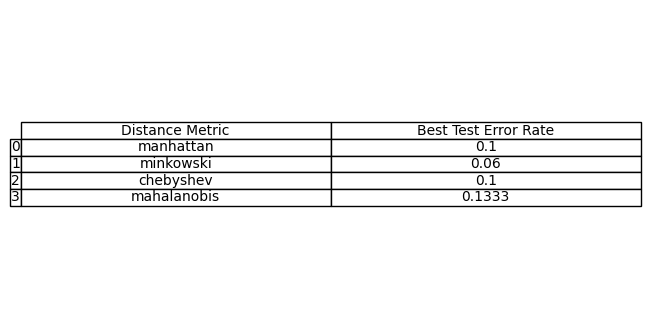

In [25]:
# Create a list of data for the table
metrics = {'manhattan': round(best_test_error_rate_manhattan,4),
        'minkowski': round(best_test_error_rate_minkowski,4),
        'chebyshev': round(best_test_error_rate_chebyshev,4),
        'mahalanobis': round(best_test_error_rate_mahalanobis,4)}
        

# Creating a table for the different metrics
df = pd.DataFrame(metrics.items(), columns=['Distance Metric', 'Best Test Error Rate'])

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
tbl = table(ax, df, loc='center', cellLoc='center')
plt.show()

# (e) Weighted Decision

### Euclidean

In [26]:
train_errors_euclidian = []
test_errors_euclidian = []

# Iterate through different values of k
for k in list(range(1, 200, 5)):
    
    # Create KNN classifier with weighted voting using Euclidean distance
    knn_classifier_euclidian_distance = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn_classifier_euclidian_distance.fit(X_train, y_train)
    
    # Predict on the training and test data
    y_train_pred = knn_classifier_euclidian_distance.predict(X_train)
    y_test_pred = knn_classifier_euclidian_distance.predict(X_test)
    
    # Calculate test errors 
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    train_errors_euclidian.append(train_error)
    test_errors_euclidian.append(test_error)

### Plotting training and testing errors against k

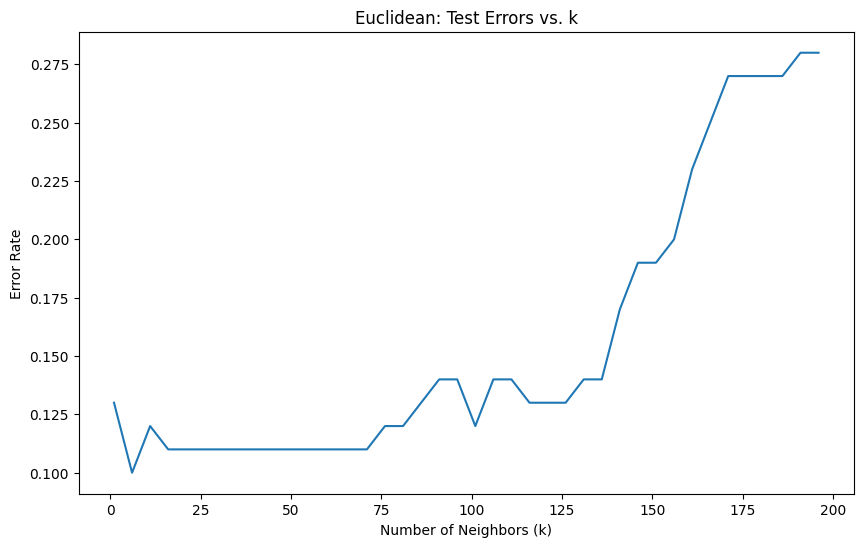

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, 200, 5)), test_errors_euclidian, label='Test Error')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Euclidean: Test Errors vs. k')
plt.show()

### Best test error rate

In [28]:
print(f"Test Test Error Rate for the KNN using Euclidian Distance: {min(test_errors)}")

Test Test Error Rate for the KNN using Euclidian Distance: 0.06000000000000005


### Manhattan

In [29]:
test_errors_manhattan = []

# Iterate through different values of k
for k in list(range(1, 200, 5)):
    
    # Create KNN classifier with weighted voting using Euclidean distance
    knn_classifier_manhattan_distance = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='manhattan')
    knn_classifier_manhattan_distance.fit(X_train, y_train)
    
    # Predict on the training and test data
    y_train_pred = knn_classifier_manhattan_distance.predict(X_train)
    y_test_pred = knn_classifier_manhattan_distance.predict(X_test)
    
    # Calculate test errors 
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    test_errors_manhattan.append(test_error)


### Plotting training and testing errors against k

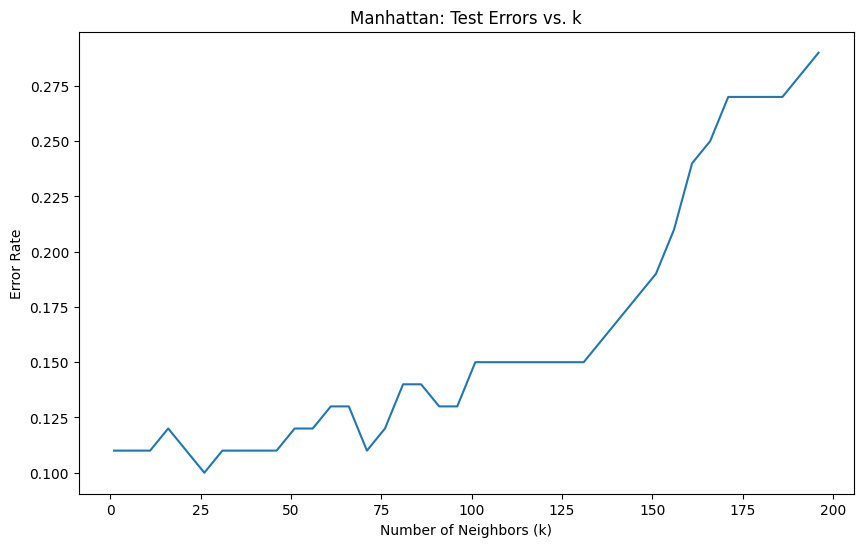

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(list(range(1, 200, 5)), test_errors_manhattan, label='Test Error')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Manhattan: Test Errors vs. k')
plt.show()

### Best test error rate

In [31]:
print(f"Test Test Error Rate for the KNN using the Mahhattan Distance: {min(test_errors)}")

Test Test Error Rate for the KNN using the Mahhattan Distance: 0.06000000000000005


### Chebyshev

In [32]:
train_errors_chebyshev = []
test_errors_chebyshev = []

# Iterate through different values of k
for k in list(range(1, 200, 5)):
    
    # Create KNN classifier with weighted voting using Euclidean distance
    knn_classifier_chebyshev_distance = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='chebyshev')
    knn_classifier_chebyshev_distance.fit(X_train, y_train)
    
    # Predict on the training and test data
    y_train_pred = knn_classifier_chebyshev_distance.predict(X_train)
    y_test_pred = knn_classifier_chebyshev_distance.predict(X_test)
    
    # Calculate test errors 
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)

    train_errors_chebyshev.append(train_error)
    test_errors_chebyshev.append(test_error)


### Plotting training and testing errors against k

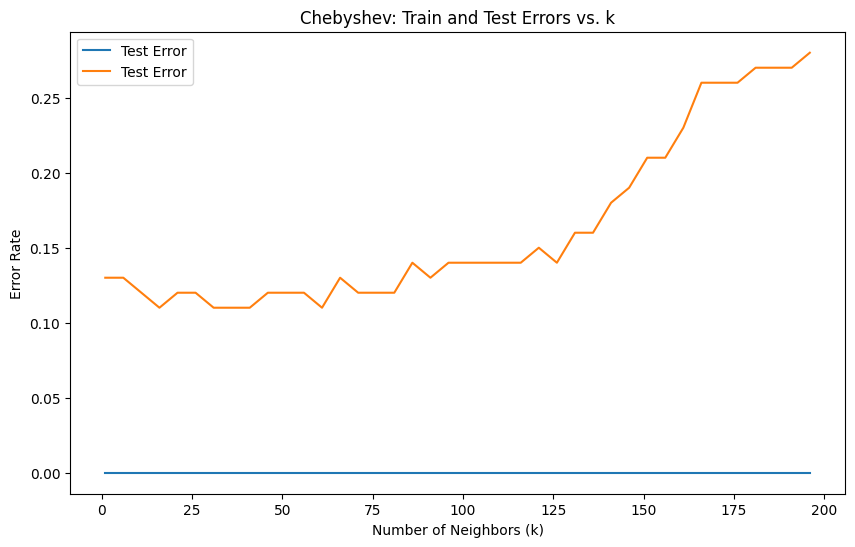

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, 200, 5)), train_errors_chebyshev, label='Test Error')
plt.plot(list(range(1, 200, 5)), test_errors_chebyshev, label='Test Error')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Chebyshev: Train and Test Errors vs. k')
plt.legend()
plt.show()

### Best test error rate

In [34]:
print(f"Test Error Rate for the KNN using the Mahhattan Distance: {min(test_errors)}")

Test Error Rate for the KNN using the Mahhattan Distance: 0.06000000000000005


# (f) Training Error Rate

The lowest training error rate I got in this homework was zero. I think I may be overfitting the data in some instances, but i'm not quite sure. I'm only getting an error rate of zero once I switch change the weights paramater in the model (weights='distance'). But the best training error I got when I wasn't using weights='distance' was for the Minkowski Distance, 0.12857142857142856